In [17]:
import numpy as np
import os

<h1 id="definition" style="color:black; background:whte; border:0.5px dotted;"> 
    <center>Definition
        <a class="anchor-link" href="#definition" target="_self">¶</a>
    </center>
</h1>

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.<br>
<br>

### Data preparation

In [18]:
corpora_dir = r"manifesto"

file_list = [] #used to store lis of files
for root,_,files in os.walk(corpora_dir):
    for filename in files :
        file_list.append(os.path.join(root,filename))

print("Read",len(file_list),"file....")


docs = []

# Reading all the files
for files in file_list:
    with open(files,'r',encoding = "utf-8") as fin:
        try : 
            str_form = fin.read().lower().replace("\n",'')
            docs.append(str_form)
        except UnicodeDecodeError:
        # Ignoring weird (special) characters
           pass

data = "".join(docs)

print("corpus length :", len(data))


Read 1 file....
corpus length : 222479


<h1 id="dictionaries" style="color:black; background:whte; border:0.5px dotted;"> 
    <center>Dictionaries
        <a class="anchor-link" href="#dictionaries" target="_self">¶</a>
    </center>
</h1>

In [19]:
# Creating a dictionary
chars = sorted(set(data))

char_to_idx = {c:i for (i,c) in enumerate(chars)}
idx_to_char = {i:c for (i,c) in enumerate(chars)}

<h1 id="parameters" style="color:black; background:whte; border:0.5px dotted;"> 
    <center>Parameters
        <a class="anchor-link" href="#parameters" target="_self">¶</a>
    </center>
</h1>

In [20]:
data_size, char_size = len(data), len(chars)

hidden_size = 10
weight_sd = 0.1
z_size = hidden_size + char_size
t_steps = 25


<h1 id="activation-functions" style="color:black; background:whte; border:0.5px dotted;"> 
    <center>Activation Functions
        <a class="anchor-link" href="#activation-functions" target="_self">¶</a>
    </center>
</h1>

In [21]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(y):
    return y * (1 - y)

def tanh(x):
    return np.tanh(x)

def dtanh(y):
    return 1 - y * y

<h1 id="architecture" style="color:black; background:whte; border:0.5px dotted;"> 
    <center>Architecture
        <a class="anchor-link" href="#architecture" target="_self">¶</a>
    </center>
</h1>

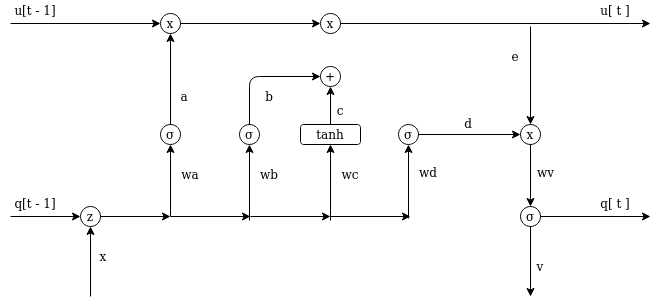

<h1 id="implementation" style="color:black; background:whte; border:0.5px dotted;"> 
    <center>Implementation
        <a class="anchor-link" href="#implementation" target="_self">¶</a>
    </center>
</h1>

In [22]:
def forward(x, u, q):
    z = np.row_stack((q, x))

    a = sigmoid(np.dot(wa, z) + ba)
    b = sigmoid(np.dot(wb, z) + bb)
    c = tanh(np.dot(wc, z) + bc)
    d = sigmoid(np.dot(wd, z) + bd)

    e = a * u + b * c
    h = d * tanh(e)

    v = np.dot(wv, h) + bv
    y = np.exp(v) / np.sum(np.exp(v))

    return z, a, b, c, d, e, h, v, y

<h2 id="SGD" style="color:black; background:whte; border:0.5px dotted;"> 
    <center>SGD
        <a class="anchor-link" href="#implementation" target="_self">¶</a>
    </center>
</h2>

In [23]:
def optimize(grads, theta, lr=0.05):
    dwa, dwb, dwc, dwd, dwv, dba, dbb, dbc, dbd, dbv = grads
    wa, wb, wc, wd, wv, ba, bb, bc, bd, bv = theta
    
    wa -= dwa * lr
    wb -= dwb * lr
    wc -= dwc * lr
    wd -= dwd * lr
    wv -= dwv * lr
    
    ba -= dba * lr
    bb -= dbb * lr
    bc -= dbc * lr
    bd -= dbd * lr
    bv -= dbv * lr
    
    return wa, wb, wc, wd, wv, ba, bb, bc, bd, bv

<h1 id="initialize" style="color:black; background:whte; border:0.5px dotted;"> 
    <center>Initialize variables
        <a class="anchor-link" href="#initialize" target="_self">¶</a>
    </center>
</h1>

In [24]:
losses = {}
z, a, b, c, d, e, h, v, y = {}, {}, {}, {}, {}, {}, {}, {}, {}
q, x, u = {}, {}, {}

In [25]:
wa, wb, wc, wd = [np.random.randn(hidden_size, z_size) * weight_sd + 0.5 for x in range(4)]
ba, bb, bc, bd = [np.zeros((hidden_size, 1)) for x in range(4)]

# output
wv = np.random.randn(char_size, hidden_size) * weight_sd
bv = np.zeros((char_size, 1))

In [26]:
q[-1] = np.zeros((hidden_size, 1))
u[-1] = np.zeros((hidden_size, 1))

pointer = 25
t_steps = 25

inputs = ([char_to_idx[ch] for ch in data[pointer: pointer + t_steps]])
targets = ([char_to_idx[ch] for ch in data[pointer + 1: pointer + t_steps + 1]])

<h1 id="training" style="color:black; background:whte; border:0.5px dotted;"> 
    <center>Training
        <a class="anchor-link" href="#training" target="_self">¶</a>
    </center>
</h1>

In [27]:
for epoch in range(1000):
    
    loss = 0
    
    # Forward propagation
    for t in range(len(inputs)):
        x[t] = np.zeros((char_size, 1))
        x[t][inputs[t]] = 1

        z[t], a[t], b[t], c[t], d[t], e[t], h[t], v[t], y[t] = forward(x[t], u[t - 1], q[t - 1])

        u[t], q[t] = e[t], h[t]

        # log loss
        loss += -np.log(y[t][targets[t], 0])


    dh_next = np.zeros_like(q[0])
    de_next = np.zeros_like(u[0])
    dwa, dwb, dwc, dwd, dwv, dba, dbb, dbc, dbd, dbv = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

    # Backward propagation
    for t in reversed(range(len(inputs))):
        target = targets[t]

        dv = np.copy(y[t])
        dv[target] -= 1

        dwv += np.dot(dv, h[t].T)
        dbv += dv

        dh = np.dot(wv.T, dv)
        dh += dh_next

        dd = dh * tanh(e[t])
        dd = dsigmoid(d[t]) * dd

        dwd += np.dot(dd, z[t].T)
        dbd += dd

        de = np.copy(de_next)
        de += dh * d[t] * dtanh(tanh(e[t]))

        dc = de * b[t]
        dc = dtanh(c[t]) * dc

        dwc += np.dot(dc, z[t].T)
        dbc += dc

        db = de * dc
        db = dsigmoid(b[t]) * db

        dwb += np.dot(db, z[t].T)
        dbb += db

        da = de * u[t - 1]
        da = dsigmoid(a[t]) * da

        dwa += np.dot(da, z[t].T)
        dba += da

        dz = (np.dot(wa.T, da) 
              + np.dot(wb.T, db) 
              + np.dot(wc.T, dc) 
              + np.dot(dd.T, dd))

        dh_next = dz[:hidden_size, :]
        de_next = a[t] * de

    
    grads = dwa, dwb, dwc, dwd, dwv, dba, dbb, dbc, dbd, dbv
    theta = wa, wb, wc, wd, wv, ba, bb, bc, bd, bv

    # optimize with SGD the training data
    wa, wb, wc, wd, wv, ba, bb, bc, bd, bv = optimize(grads, theta)
        
    losses[epoch] = loss

<h1 id="analyze" style="color:black; background:whte; border:0.5px dotted;"> 
    <center>Analyze
        <a class="anchor-link" href="#analyze" target="_self">¶</a>
    </center>
</h1>

In [28]:
import matplotlib.pyplot as plt

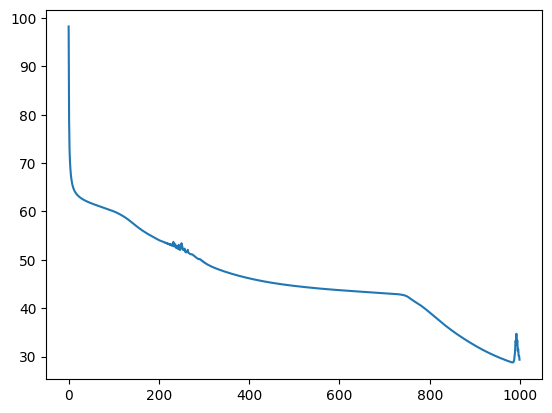

In [29]:
plt.plot(list(losses.keys()), [losses[x] for x in list(losses.keys())])